<a href="https://colab.research.google.com/github/KarthikReddy2409/Airbnb-The-Amsterdam-story-with-interactive-maps/blob/master/Airbnb_The_Amsterdam_story_with_interactive_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#to make the interactive maps
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap

#to make the plotly graphs
import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

#text mining
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

In [0]:
pip install geopandas

     |████████████████████████████████| 921kB 2.7MB/s 
     |████████████████████████████████| 10.1MB 43.8MB/s 
     |████████████████████████████████| 11.8MB 41.7MB/s 


In [0]:
pip install chart_studio 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**The listings and listing details files:**

The listings file is an overview file that insideairbnb labels as "good for visualizations". The unique identifier in the dataset is the "listing" id. This is basically the id of the advertisement. Overall, there were 20,025 Airbnb-listings in Amsterdam on December 7th, 2019.

In [0]:
# Reading the dataset
listings = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AirBnB/listings.csv', index_col = 'id')
listings_details = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AirBnB/listings_details.csv', index_col='id', low_memory = False)
calender = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AirBnB/calendar.csv', index_col= ['listing_id'])
reviews = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AirBnB/reviews.csv', index_col=['date'])

print(listings.shape)

(20025, 15)


The listings file contains 15 variables per listing besides the id.

In [0]:
listings.columns

Index(['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

The listings_details file contains a total of 96 variables. I am not going to use all of these, but selectively joined a number of variables that seemed useful to me for this EDA.

In [0]:
target_columns = ["property_type", "accommodates", "first_review", "review_scores_value", "review_scores_cleanliness", "review_scores_location", "review_scores_accuracy", "review_scores_communication", "review_scores_checkin", "review_scores_rating", "maximum_nights", "listing_url", "host_is_superhost", "host_about", "host_response_time", "host_response_rate", "street", "weekly_price", "monthly_price", "market"]
listings = pd.merge(listings, listings_details[target_columns], on='id', how='left')
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20025 entries, 2818 to 40655209
Data columns (total 35 columns):
name                              19991 non-null object
host_id                           20025 non-null int64
host_name                         19867 non-null object
neighbourhood_group               0 non-null float64
neighbourhood                     20025 non-null object
latitude                          20025 non-null float64
longitude                         20025 non-null float64
room_type                         20025 non-null object
price                             20025 non-null int64
minimum_nights                    20025 non-null int64
number_of_reviews                 20025 non-null int64
last_review                       17621 non-null object
reviews_per_month                 17621 non-null float64
calculated_host_listings_count    20025 non-null int64
availability_365                  20025 non-null int64
property_type                     20025 non-null ob

We see that neighbourhood_group is not useful in Amsterdam, as it contains zero non-null objects. Below, I getting rid of this variable, and am showing the head of the dataframe that I am going to work with.

In [0]:
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'].str.strip('%'))

listings.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,property_type,accommodates,first_review,review_scores_value,review_scores_cleanliness,review_scores_location,review_scores_accuracy,review_scores_communication,review_scores_checkin,review_scores_rating,maximum_nights,listing_url,host_is_superhost,host_about,host_response_time,host_response_rate,street,weekly_price,monthly_price,market
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,NaN,Oostelijk Havengebied - Indische Buurt,52.36575,4.94142,Private room,59,3,277,2019-11-21,2.13,1,0,Apartment,2,2009-03-30,10.0,10.0,9.0,10.0,10.0,10.0,98.0,15,https://www.airbnb.com/rooms/2818,t,"Upon arriving in Amsterdam, one can imagine as...",within an hour,100.0,"Amsterdam, North Holland, Netherlands",NaN,"$1,500.00",Amsterdam
20168,Studio with private bathroom in the centre 1,59484,Alexander,NaN,Centrum-Oost,52.36509,4.89354,Private room,80,1,306,2019-12-05,2.57,2,198,Townhouse,2,2010-03-02,9.0,10.0,10.0,10.0,10.0,10.0,89.0,1000,https://www.airbnb.com/rooms/20168,f,Secondary phone nr. + (Phone number hidden by ...,within an hour,100.0,"Amsterdam, North Holland, Netherlands",NaN,NaN,Amsterdam
25428,Lovely apt in City Centre (w.lift) near Jordaan,56142,Joan,NaN,Centrum-West,52.37297,4.88339,Entire home/apt,125,14,3,2019-05-11,0.13,2,71,Apartment,3,2018-01-21,10.0,10.0,10.0,10.0,10.0,10.0,100.0,60,https://www.airbnb.com/rooms/25428,f,"We are a retired couple who live in NYC, and h...",within an hour,100.0,"Amsterdam, North Holland, Netherlands",$650.00,"$2,000.00",Amsterdam
27886,"Romantic, stylish B&B houseboat in canal district",97647,Flip,NaN,Centrum-West,52.38673,4.89208,Private room,155,2,206,2019-11-11,2.14,1,251,Houseboat,2,2012-01-09,10.0,10.0,10.0,10.0,10.0,10.0,99.0,730,https://www.airbnb.com/rooms/27886,t,"Marjan works in ""eye"" the dutch filmmuseum, an...",within an hour,100.0,"Amsterdam, North Holland, Netherlands",$810.00,"$2,500.00",Amsterdam
28871,Comfortable double room,124245,Edwin,NaN,Centrum-West,52.36719,4.89092,Private room,75,2,318,2019-11-23,2.81,3,134,Apartment,2,2010-08-22,10.0,10.0,10.0,10.0,10.0,10.0,98.0,1825,https://www.airbnb.com/rooms/28871,t,Hi,within an hour,100.0,"Amsterdam, North Holland, Netherlands",$499.00,"$1,956.00",Amsterdam


**Data Exploration**

* Neighbourhood "De Baarsjes" holds most listings, and altogether eight neigbourhoods have over one thousand listings.

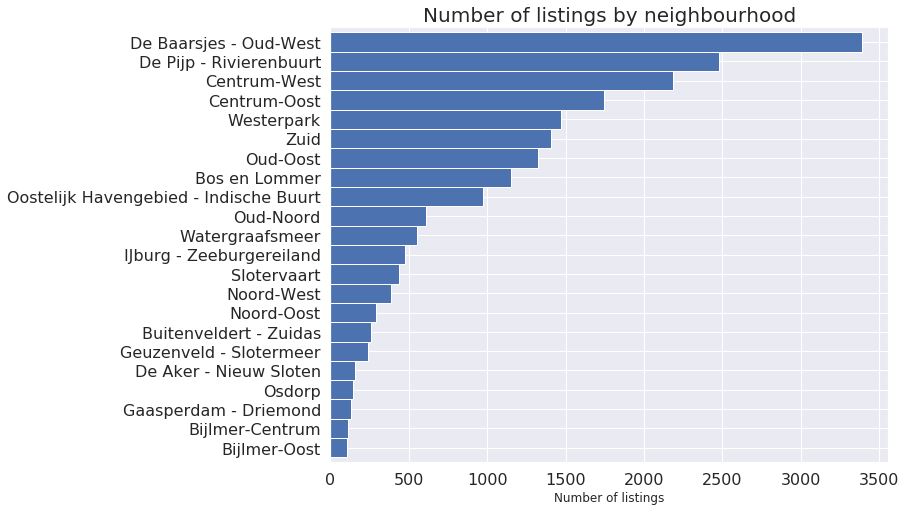

In [0]:
feq=listings['neighbourhood'].value_counts().sort_values(ascending=True)
feq.plot.barh(figsize=(10, 8), color='b', width=1)
plt.title("Number of listings by neighbourhood", fontsize=20)
plt.xlabel('Number of listings', fontsize=12)
plt.show()

Below, you can see that most listings are in the city centre. This map is interactive, and you can zoom-in on the clusters to eventually find the individual locations of the listings.

In [0]:
lats2018 = listings['latitude'].tolist()
lons2018 = listings['longitude'].tolist()
locations = list(zip(lats2018, lons2018))

map1 = folium.Map(location=[52.3680, 4.9036], zoom_start=11.5)
FastMarkerCluster(data=locations).add_to(map1)
map1

**Room Types And Property Types:**

The room type is very important in Amsterdam, because Amsterdam has a rule that Entire homes/apartments can only be rented out via Airbnb for a maximum of 60 days a year. Below, we can see that this restriction applies to most of the listings.

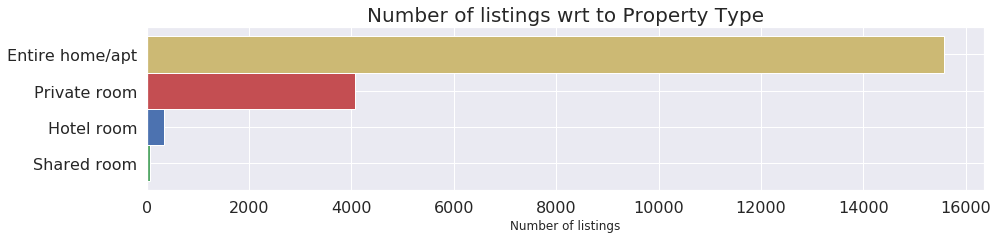

In [0]:
freq = listings['room_type']. value_counts().sort_values(ascending=True)
freq.plot.barh(figsize=(15, 3), width=1, color = ["g","b","r",'y'])
plt.title("Number of listings wrt to Property Type", fontsize=20)
plt.xlabel('Number of listings', fontsize=12)
plt.show()

**Property Types:**

**Summary:**

* Below I have only displayed properties with a minimum of 100 listings.

* Majority of the properties listed in Amsterdam are **Apartments**.


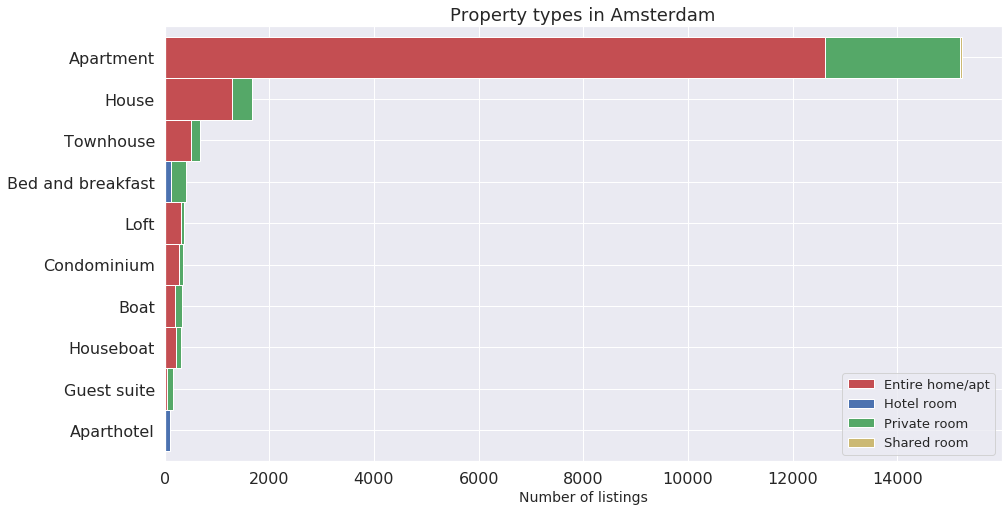

In [0]:
prop = listings.groupby(['property_type','room_type']).room_type.count()
prop = prop.unstack()
prop['total'] = prop.iloc[:,0:3].sum(axis = 1)
prop = prop.sort_values(by = ['total'])
prop = prop[prop['total']>=100]
prop = prop.drop(columns=['total'])
prop.plot(kind='barh',stacked=True, color = ["r","b","g",'y'],
              linewidth = 1, grid=True, figsize=(15,8), width=1)
plt.title('Property types in Amsterdam', fontsize=18)
plt.xlabel('Number of listings', fontsize=14)
plt.ylabel("")
plt.legend(loc = 4,prop = {"size" : 13})
plt.rc('ytick', labelsize=13)
plt.show()

**Accommodation:**

* Most listings are for 2 people. In addition Airbnb uses a maximum of 16 guests per listing.

* Amsterdam has an additional restriction. Due to **fire hazard considerations** and also taking possible noisy group into account, owners are only allowed to rent their property to groups with a **maximum of 4 people**.

* This actually means that the listings that indicate that the maximum number of **people is above 4 are breaking this rule!**

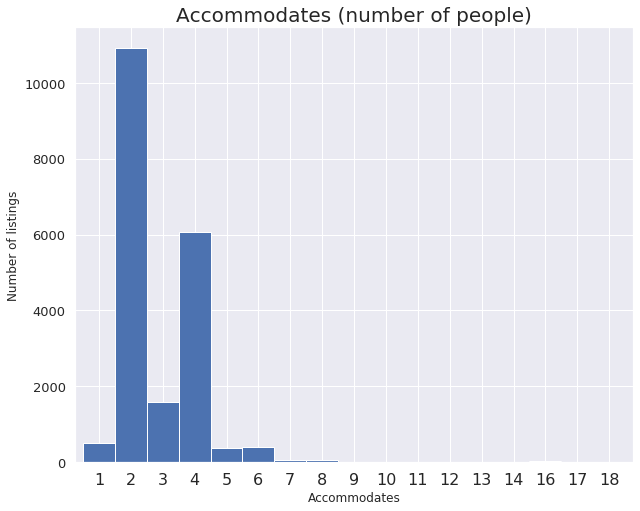

In [0]:
feq=listings['accommodates'].value_counts().sort_index()
feq.plot.bar(figsize=(10, 8), color='b', width=1, rot=0)
plt.title("Accommodates (number of people)", fontsize=20)
plt.ylabel('Number of listings', fontsize=12)
plt.xlabel('Accommodates', fontsize=12)
plt.show()

**Amsterdam Rules:** 

* The maximum number of guests is 4 (see also previous section)

* The maximum number for short-term rental is 60 days per calendar year. This rules is only for renting out entire properties, and therefore does not apply to renting out private rooms. This rule was already enforced by Airbnb (after 60 days of bookings, Airbnb closes the availability of the listing for the rest of the year). As you can read in the article, the number will be lowered to a maximum of 30 days a year.

* Amsterdam intends to ban Airbnb entirely in three neighourhoods: de Wallen (Red Light District), Kinkerbuurt and Haarlemmerbuurt

* For renting out Private Rooms, there is also the restriction that an owner cannot rent-out rooms that accumulate to more than 40% of the total surface (in square meters)


**Finding Illegal Hotels:**

Any owner renting out more than **40% of his/her property as Private Rooms** is breaking the last rule mentioned in the previous section, but in this section I am only going to look for extreme cases.

Below, I am displaying the five hosts having the **most Private Room listings**. Unfortunately, Airbnb does not give the addresses of the listings. The field "street" is actually in the database, but as you can see these are certainly not full, real addresses! Therefore, from this table I cannot say if these listings from are in fact in the same house.

In [0]:
private = listings[listings['room_type'] == "Private room"]
host_private = private.groupby(['host_id', 'host_name', 'street']).size().reset_index(name='private_rooms').sort_values(by=['private_rooms'], ascending=False)
host_private.head()

,host_id,host_name,street,private_rooms
1977,44168250,Ruben,"Amsterdam, Noord-Holland, Netherlands",16
2300,67005410,Feliciano,"Amsterdam, Noord-Holland, Netherlands",15
839,10076897,Geraldine,"Amsterdam, Noord-Holland, Netherlands",13
2050,47770842,Sven,"Amsterdam, Noord-Holland, Netherlands",10
3442,300888539,Cosimo,"Amsterdam, Noord-Holland, Netherlands",9


However, we have the **GPS-coordinates of the listings**. To me, it seems very likely that all private rooms that host Feliciano offers are in fact in the same building (only minor variations in latitude/longitude). Although this host might have a hotel license, his listings seem suspicious too me (what is the name of the hotel?)! I would advise the municipality of Amsterdam to check if no rules are broken in this case.

In [0]:
feliciano = private[private['host_id']== 67005410]
feliciano = feliciano[['name','host_id', 'host_name', 'latitude', 'longitude']]
feliciano.index.name = "listing_id"
feliciano

,name,host_id,host_name,latitude,longitude
listing_id,,,,,
12392592,Hotel in the heart of Amsterdam 2p,67005410,Feliciano,52.37525,4.90032
12444222,Hotel in the heart of Amsterdam 4p,67005410,Feliciano,52.37513,4.89969
12446710,Hotel in the heart of Amsterdam 3p,67005410,Feliciano,52.37469,4.90027
12451293,"Hotel in the heart of Amsterdam, Single room",67005410,Feliciano,52.37468,4.89892
12579177,Hotel in the heart of Amsterdam 2p,67005410,Feliciano,52.37457,4.89831
12582071,Hotel in the heart of Amsterdam 3p,67005410,Feliciano,52.37341,4.90002
12865293,Hotel in the heart of Amsterdam 2p,67005410,Feliciano,52.37508,4.90019
12865495,Hotel in the heart of Amsterdam 2p,67005410,Feliciano,52.37340,4.89843
12898673,Hotel in the heart of Amsterdam 1p,67005410,Feliciano,52.37335,4.89834


**Unwanted Effect Of Professional Hosts:**

At the moment, Amsterdam has no rule in place to prevent professional hosting activities. I can imagine that having the option to outsource these activities leads to even more listings. At the moment, about **75% of the hosts only have one listing.** I assume that hosts with just a couple of listings are likely to also be the host for a couple of friends. However, we see that there are extreme cases. I believe that it becomes unlikely that hosts with more than 10 listings are just doing this for themselves and friends and family.

In [0]:
freq = listings.groupby(['host_id']).size().reset_index(name='num_host_listings')
host_prop = freq.groupby(['num_host_listings']).size().reset_index(name='count').transpose()
host_prop.columns = host_prop.iloc[0]
host_prop = host_prop.drop(host_prop.index[0])
host_prop

num_host_listings,1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,18,19,20,22,27,28,29,33,72
count,15991,1175,191,52,33,14,10,6,5,1,5,2,3,2,1,1,1,2,1,1,1,2,1,1


Below, I diplay the hosts with more that 20 listings. Unfortunately, the host_about is not fully scraped. However as this dataset is extremely recent, it was not hard for me to find the host description of the host with 200+ listings on airbnb.com. As you can see, this host clearly is a professional host!

As it is probably hard to implement and control a measure that completely forbids professional hosting activities, I would advise the municipality of Amsterdam to consider setting a maximum number of listings per host. If Amsterdam would set this at for instance 10 (and manages to get this implemented in Airbnb's systems), it would becomes much harder to exploit hosting at Airbnb as a professional activity.

In [0]:
freq = listings.groupby(['host_id', 'host_name', 'host_about']).size().reset_index(name='num_host_listings')
freq = freq.sort_values(by=['num_host_listings'], ascending=False)
freq = freq[freq['num_host_listings'] >= 20]
freq

,host_id,host_name,host_about,num_host_listings
3216,7594884,"Ruben, Sarah & Lindy","We are Ruben, Sarah & Lindy, we rent out prope...",33
8648,113977564,Willem,I own a hotel in Amsterdam and manage properti...,29
4753,14874061,Jasper,"I really like to meet nice people, having good...",29
493,1464510,Michiel And Jane,"Hi, we are Michiel & Jane,\r\n\r\nWe are a tea...",28
7836,65859990,Martijn,"Hi, I'm Martijn, \r\n\r\nWe are a team of prof...",27
7140,44168250,Ruben,Running a family business in real estate & tou...,20


**Advice To Tourists:**

**Average daily price per neighbourhood**

In order to compare "apples to apples" I have only selected the most common type of accommodation, which is accommodation for 2 persons. As expected, accommodation in the city centre is the most expensive.

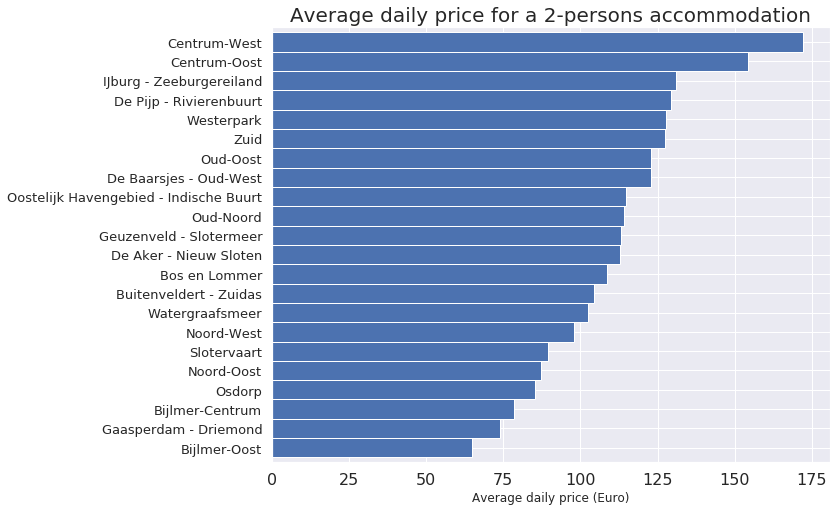

In [0]:
feq = listings[listings['accommodates']==2]
feq = feq.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)
feq.plot.barh(figsize=(10, 8), color='b', width=1)
plt.title("Average daily price for a 2-persons accommodation", fontsize=20)
plt.xlabel('Average daily price (Euro)', fontsize=12)
plt.ylabel("")
plt.show()

Below you can find the neighbourhoods on a map. This map is interactive. Hovering over the **polygons shows the name of the neighbourhood, and the average price for 2-persons accommodations.**

In [0]:
adam = gpd.read_file("/content/drive/My Drive/Colab Notebooks/AirBnB/neighbourhoods.geojson")
feq = pd.DataFrame([feq])
feq = feq.transpose()
adam = pd.merge(adam, feq, on='neighbourhood', how='left')
adam.rename(columns={'price': 'average_price'}, inplace=True)
adam.average_price = adam.average_price.round(decimals=0)

map_dict = adam.set_index('neighbourhood')['average_price'].to_dict()
color_scale = LinearColormap(['yellow','red'], vmin = min(map_dict.values()), vmax = max(map_dict.values()))

def get_color(feature):
    value = map_dict.get(feature['properties']['neighbourhood'])
    return color_scale(value)

map3 = folium.Map(location=[52.3680, 4.9036], zoom_start=11)
folium.GeoJson(data=adam,
               name='Amsterdam',
               tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'average_price'],
                                                      labels=True,
                                                      sticky=False),
               style_function= lambda feature: {
                   'fillColor': get_color(feature),
                   'color': 'black',
                   'weight': 1,
                   'dashArray': '5, 5',
                   'fillOpacity':0.5
                   },
               highlight_function=lambda feature: {'weight':3, 'fillColor': get_color(feature), 'fillOpacity': 0.8}).add_to(map3)
map3

**Plotting rating for the location and Location versus Price**

In this section, I am grouping the review scores for the location by neighbourhood (only listings with at least 10 reviews). Although I expect the distance to the city centre to an important factor, these score should also take other things into account. Other factors may include:

The safety of a location (as displayed in the previous section)
Noise. If a listing is centrally located, but surrounded by noisy bars, that should cost points in the location review score.
If a listing is located outside the city centre but well connected by public transportation, it should get bonus points for that.
Facilities near the listing. Are there any supermarkets, bars and restaurants nearby?

Some people may be looking for free parking if they come by car (parking is very expensive in Amsterdam in general).
Below we see that the central neighbourhoods, which were generally also the most expensive, generally also score higher on location review score. If I would calculate the distance to the city centre for each listing, I expect to see pretty strong correlations between this distance with both price and location review score.

When looking at the average review score, I am surprised to see that the average is above 8/10 for all neighbourhoods! I know that Amsterdam is a small city (much smaller than many people might think!). Therefore, it does not take much time to get to the city centre from anywhere, which might explain the high averages to a certain extend. My personal advice to tourists would be to consider more affordable accommodation outside the city centre, in a safe neighbourhood, and with good public transportation connections to the city centre anyway. However, are the differences between the best locations and outside neighbourhoods really that small? Let's find out in the next section!

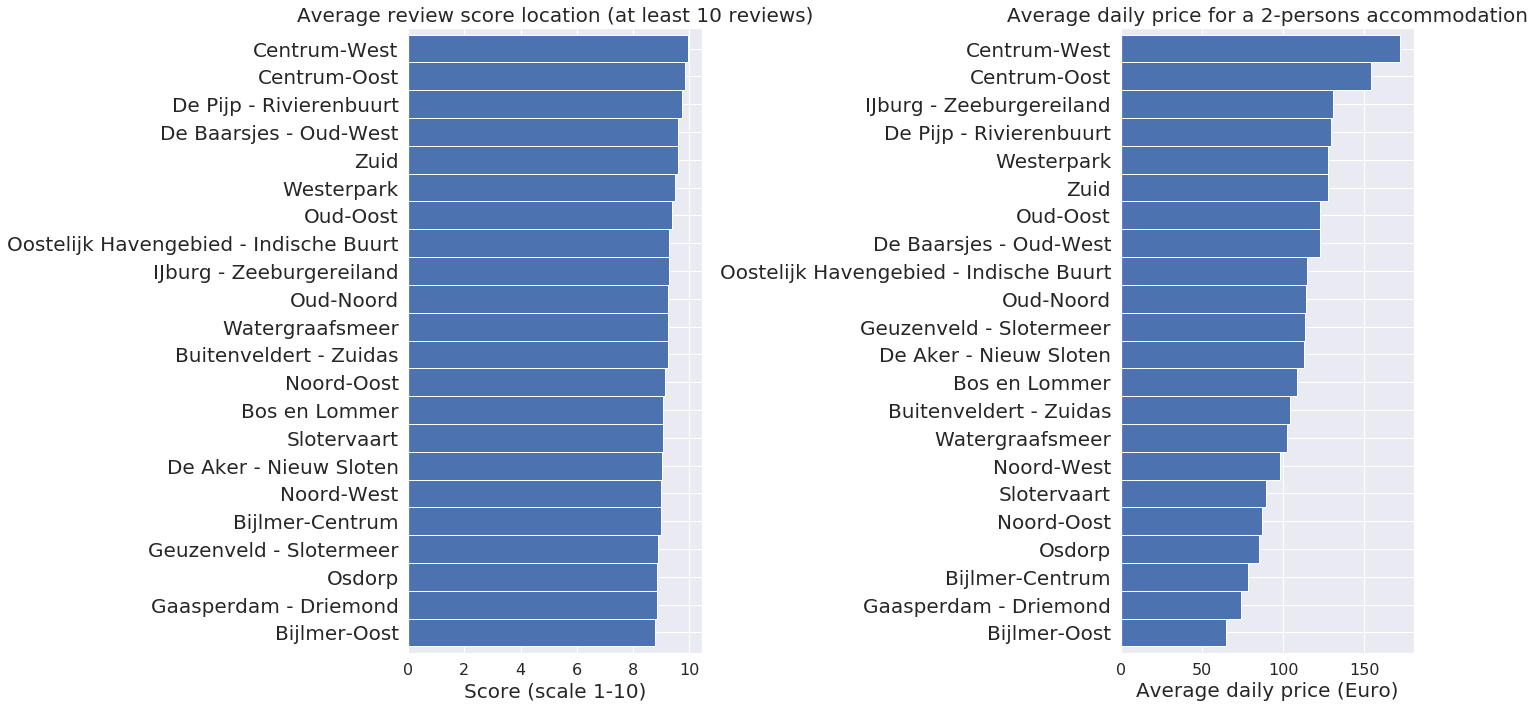

In [0]:
fig = plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq = listings[listings['number_of_reviews']>=10]
feq1 = feq.groupby('neighbourhood')['review_scores_location'].mean().sort_values(ascending=True)
ax1=feq1.plot.barh(color='b', width=1)
plt.title("Average review score location (at least 10 reviews)", fontsize=20)
plt.xlabel('Score (scale 1-10)', fontsize=20)
plt.ylabel("")

ax2 = fig.add_subplot(122)
feq = listings[listings['accommodates']==2]
feq2 = feq.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)
ax2=feq2.plot.barh(color='b', width=1)
plt.title("Average daily price for a 2-persons accommodation", fontsize=20)
plt.xlabel('Average daily price (Euro)', fontsize=20)
plt.ylabel("")

plt.tight_layout()
plt.show()

**Visualizing Reviews**:

Below you can see the scores distribution of all those categories. What caught my eye immediately is that scores seem really high across the board! A quick internet search told me that this seems common across Airbnb. 

After having seen the scores distributions, I would personally consider any score of **8 or lower to be not a good score.** If I wanted to use any of these scores in a search for accomodation, I believe the **"Value" seems most useful.** First of all, I always like to get good value for money ;-). However, the number of "10 averages" is reasonably small, which makes the indicator a bit more "distinguishable" than other indicators.

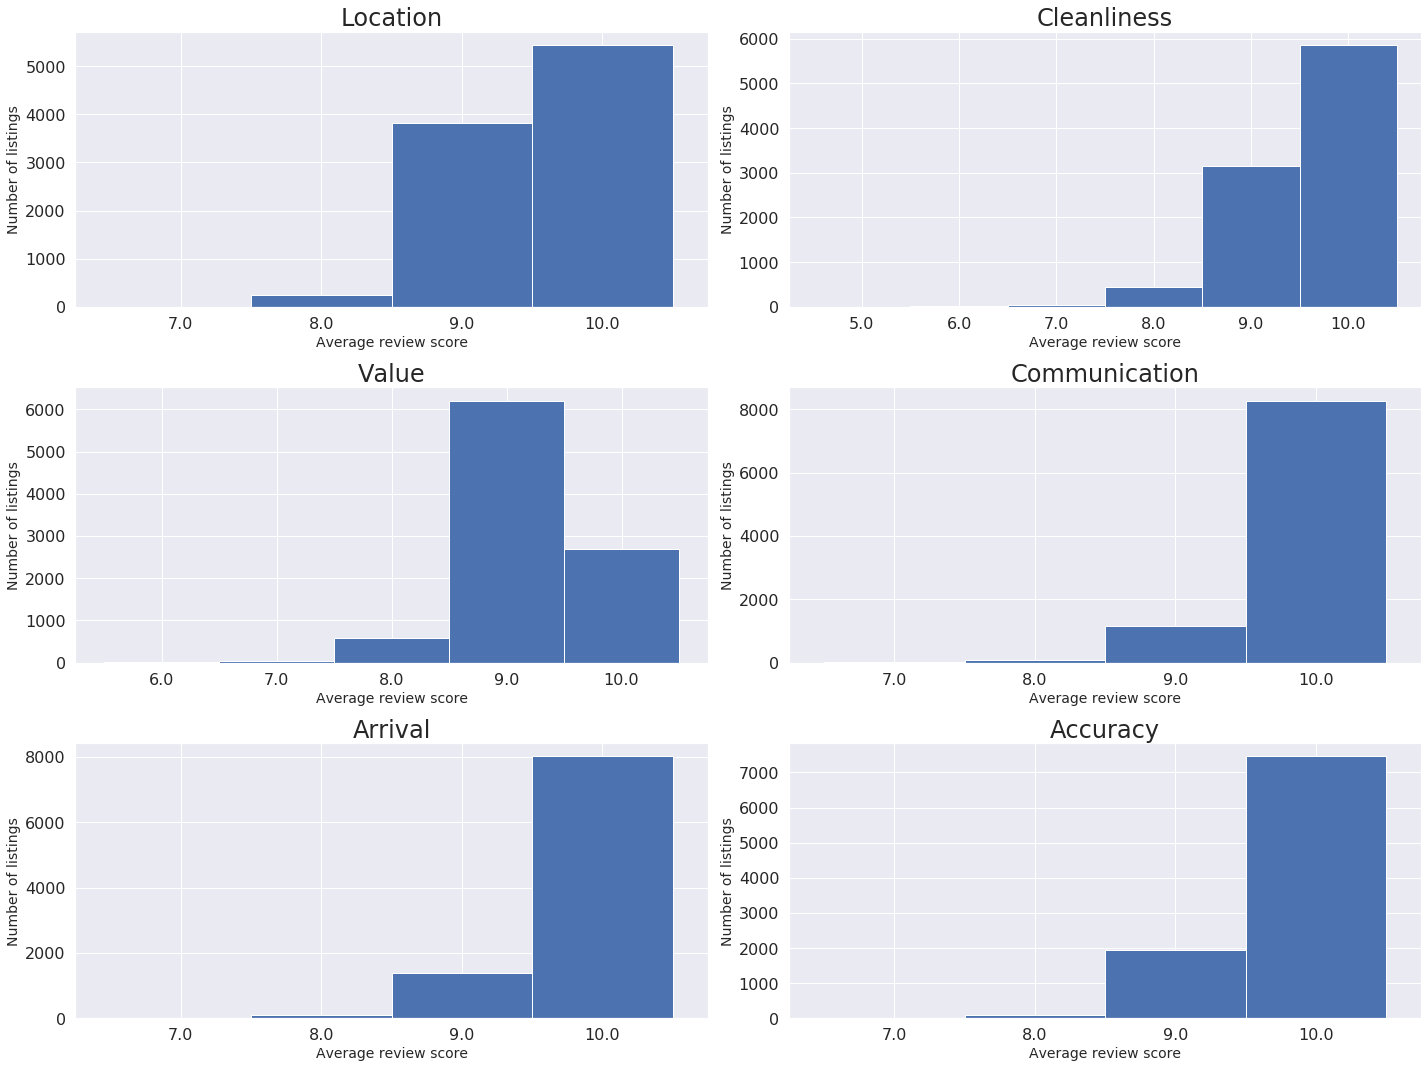

In [0]:
listings10 = listings[listings['number_of_reviews']>=10]

fig = plt.figure(figsize=(20,15))
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)

ax1 = fig.add_subplot(321)
feq=listings10['review_scores_location'].value_counts().sort_index()
ax1=feq.plot.bar(color='b', width=1, rot=0)
#ax1.tick_params(axis = 'both', labelsize = 16)
plt.title("Location", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax2 = fig.add_subplot(322)
feq=listings10['review_scores_cleanliness'].value_counts().sort_index()
ax2=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Cleanliness", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax3 = fig.add_subplot(323)
feq=listings10['review_scores_value'].value_counts().sort_index()
ax3=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Value", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax4 = fig.add_subplot(324)
feq=listings10['review_scores_communication'].value_counts().sort_index()
ax4=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Communication", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax5 = fig.add_subplot(325)
feq=listings10['review_scores_checkin'].value_counts().sort_index()
ax5=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Arrival", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax6 = fig.add_subplot(326)
feq=listings10['review_scores_accuracy'].value_counts().sort_index()
ax6=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Accuracy", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

plt.tight_layout()
plt.show()


**Finding A Good Host:**

* At Airbnb you can get the status "Superhost". From Airbnb:

* As a Superhost, you’ll have more visibility, earning potential, and exclusive rewards. It's our way of saying thank you for your outstanding hospitality.

* How to become a Superhost: Every 3 months, we check if you meet the following criteria. If you do, you'll earn or keep your Superhost status.

* Superhosts have a 4.8 or higher average overall rating based on reviews from at least 50% of their Airbnb guests in the past year.

* Superhosts have hosted at least 10 stays in the past year or, if they host longer-term reservations, 100 nights over at least 3 stays.

* Superhosts have no cancellations in the past year, unless there were extenuating circumstances.

* Superhosts respond to 90% of new messages within 24 hours.

* Below, we can see that only a small portion of the listings in Amsterdam do have a host who is Superhost.

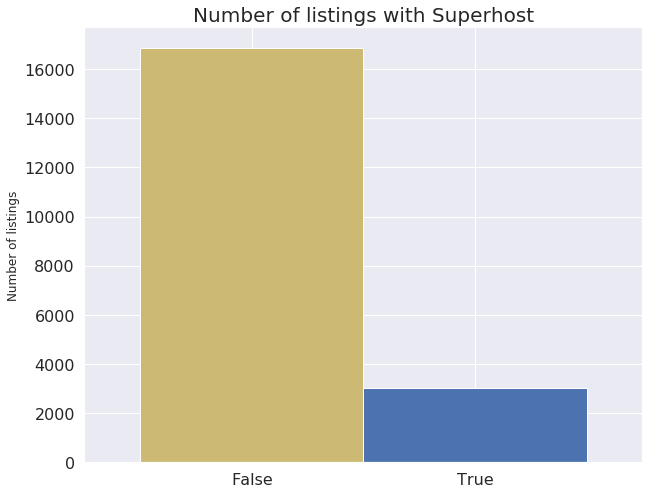

In [0]:
listings.host_is_superhost = listings.host_is_superhost.replace({"t": "True", "f": "False"})

feq=listings['host_is_superhost'].value_counts()
feq.plot.bar(figsize=(10, 8), width=1, color = ['y', 'b'], rot=0)
plt.title("Number of listings with Superhost", fontsize=20)
plt.ylabel('Number of listings', fontsize=12)
plt.show()

**Summary:**

If I were to book accomomodation, I would not necessarily look for a superhost. Actually, I would be afraid that I would pay too much as superhost will likely increase their prices. However, I would also not want to host that responds badly, or cancels a lot.

As we can see, over **5,000 of the 20,000 listings have at least 10 reviews** and respond to at least 90% of the new messages. I would consider those hosts "proven" good responders (which does not mean that a **listing with less than 10 reviews cannot have good responding hosts**; it is just not proven yet). Also, there are very few listings with hosts not replying to new messages within 24 hours.

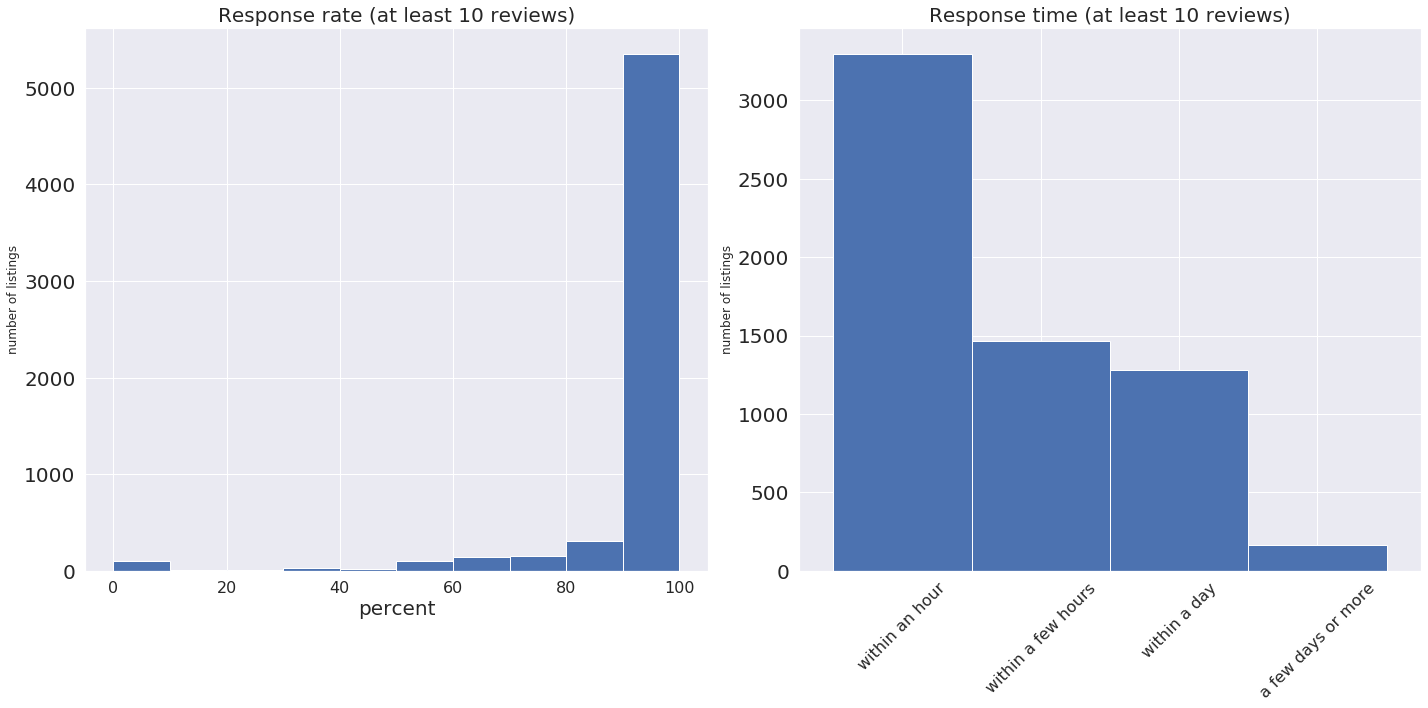

In [0]:
fig = plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq1 = listings10['host_response_rate'].dropna()
ax1= plt.hist(feq1)
plt.title("Response rate (at least 10 reviews)", fontsize=20)
plt.ylabel("number of listings")
plt.xlabel("percent", fontsize=20)

ax2 = fig.add_subplot(122)
feq2 = listings10['host_response_time'].value_counts()
ax2=feq2.plot.bar(color='b', width=1, rot=45)
plt.title("Response time (at least 10 reviews)", fontsize=20)
plt.ylabel("number of listings")

plt.tight_layout()
plt.show()

**Availability Over Time:**

The calendar file holds 365 records for each listing, which means that for each listing the price and availablity by date is specified 365 days ahead.

In [0]:
calendar = pd.read_csv("/content/drive/My Drive/Colab Notebooks/AirBnB/calendar.csv", parse_dates=['date'], index_col=['listing_id'])
calendar.price = calendar.price.str.replace(",","")
calendar['price'] = pd.to_numeric(calendar['price'].str.strip('$'))
calendar = calendar[calendar.date < '2020-12-06']

A sample of the calendar data is shown below. Important to note: availability is FALSE means that either the owner does not want to rent out his property on the specific date, or the listing has been booked for that date already. As I want to compare apples-to-apples again regarding the prices in the next section, I am merging the 'accomodates' variable with the calendar.

In [0]:
listings.index.name = "listing_id"
calendar = pd.merge(calendar, listings[['accommodates']], on = "listing_id", how = "left")
calendar.sample(15)

,date,available,price,adjusted_price,minimum_nights,maximum_nights,accommodates
listing_id,,,,,,,
36540638,2020-01-25,f,300.0,$300.00,2.0,1125.0,4
22236877,2020-11-18,f,350.0,$350.00,2.0,730.0,4
33124128,2020-10-22,f,240.0,$240.00,2.0,1125.0,4
2282124,2020-11-12,f,230.0,$230.00,4.0,1124.0,4
3005180,2020-05-20,f,195.0,$195.00,2.0,1124.0,5
21259251,2020-02-21,f,77.0,$77.00,2.0,8.0,3
35371894,2020-04-30,f,125.0,$125.00,1.0,1125.0,2
22759063,2020-03-08,f,200.0,$200.00,4.0,15.0,2
25005599,2020-12-05,f,100.0,$100.00,5.0,1125.0,2


**Text mining the Review comments:**

I don't think that the outcomes of text mining the review comments will be usefull as specific advice to tourists. 

The "reviews" file turned out to be not very interesting, as it only holds review dates for each listing, which means that it is only good for counting numbers of reviews. The "reviews_details" file holds the same information (and the same number of records), with 4 additional columns. In addition, I merged the listing's host_id and host_names with the reviews_details file.

In [0]:
reviews_details = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AirBnB/reviews_details.csv', parse_dates=['date'])
reviews_details.shape


(493815, 6)

In [0]:
reviews_details = pd.merge(reviews_details, listings[['host_id', 'host_name', 'name']], on = "listing_id", how = "left")
reviews_details = reviews_details.set_index('id')
reviews_details = reviews_details[['listing_id', 'name', 'host_id', 'host_name', 'date', 'reviewer_id', 'reviewer_name', 'comments']]
reviews_details.head()

,listing_id,name,host_id,host_name,date,reviewer_id,reviewer_name,comments
id,,,,,,,,
1191,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,2009-03-30,10952,Lam,Daniel is really cool. The place was nice and ...
1771,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,2009-04-24,12798,Alice,Daniel is the most amazing host! His place is ...
1989,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,2009-05-03,11869,Natalja,We had such a great time in Amsterdam. Daniel ...
2797,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,2009-05-18,14064,Enrique,Very professional operation. Room is very clea...
3151,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,2009-05-25,17977,Sherwin,Daniel is highly recommended. He provided all...


Below, you will find the 5 hosts with most reviews. It is interesting to see the names of hosts Martijn and Feliciano again, who have been discussed before ;-).

In [0]:
host_reviews = reviews_details.groupby(['host_id', 'host_name']).size().sort_values(ascending=False).to_frame(name = "number_of_reviews")
host_reviews.head()

,,number_of_reviews
host_id,host_name,
67005410,Feliciano,1876
124245,Edwin,1284
3278419,Matthijs,1150
3040748,Henk,1014
37658666,Ruben,985


In [0]:
reviews_details.comments.head()

id
1191    Daniel is really cool. The place was nice and ...
1771    Daniel is the most amazing host! His place is ...
1989    We had such a great time in Amsterdam. Daniel ...
2797    Very professional operation. Room is very clea...
3151    Daniel is highly recommended.  He provided all...
Name: comments, dtype: object

In [0]:
reviews_details.comments.values[2]

'We had such a great time in Amsterdam. Daniel is an excellent host! Very friendly and everytime helpful. The room was cozy, comfortable, and VERY clean. Maps, towels, mini-fridge, coffee (very tasty) and tea supplies were provided. Bathroom with all the bathroom requires. Good location - next to the tram stop and it took just around 10-15 minutes to get to the city center.\r\nTotally recommendable! '

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
# Preprocessing
#take out empty comments (530)
reviews_details = reviews_details[reviews_details['comments'].notnull()]

#remove numbers
reviews_details['comments'] = reviews_details['comments'].str.replace('\d+', '') 
#all to lowercase
reviews_details['comments'] = reviews_details['comments'].str.lower()
#remove windows new line
reviews_details['comments'] = reviews_details['comments'].str.replace('\r\n', "")
#remove stopwords (from nltk library)
stop_english = stopwords.words("english")
reviews_details['comments'] = reviews_details['comments'].apply(lambda x: " ".join([i for i in x.split() 
                                                      if i not in (stop_english)]))
# remove punctuation
reviews_details['comments'] = reviews_details['comments'].str.replace('[^\w\s]'," ")
# replace x spaces by one space
reviews_details['comments'] = reviews_details['comments'].str.replace('\s+', ' ')

reviews_details.comments.values[2] #print same comments again

'great time amsterdam daniel excellent host friendly everytime helpful room cozy comfortable clean maps towels mini fridge coffee very tasty tea supplies provided bathroom bathroom requires good location next tram stop took around minutes get city center totally recommendable '

In addition to removing the stopwords, I also wanted to remove the host names. However the list of host names contains over 5,000 words, and removing those takes a long time. Therefore, I am not removing them yet at this point.

In [0]:
host_names = reviews_details[['host_name']].drop_duplicates()
host_names = host_names.host_name.str.lower().tolist()

# reviews_details['comments'] = reviews_details['comments'].apply(lambda x: " ".join([i for i in x.split() 
#                                                       if i not in (host_names)]))

len(host_names)

5543

Below you can find my first attempt to find the most used words using the CountVectorizer() function of sklearn.

In [0]:
texts = reviews_details.comments.tolist()

vec = CountVectorizer().fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

cvec_df = pd.DataFrame.from_records(words_freq, columns= ['words', 'counts']).sort_values(by="counts", ascending=False)
cvec_df.head(10)

,words,counts
51,great,231144
3,place,188891
175,apartment,186751
53,amsterdam,186268
87,stay,182987
67,location,142185
106,us,134211
4,nice,133435
26,host,113422
5,clean,106006


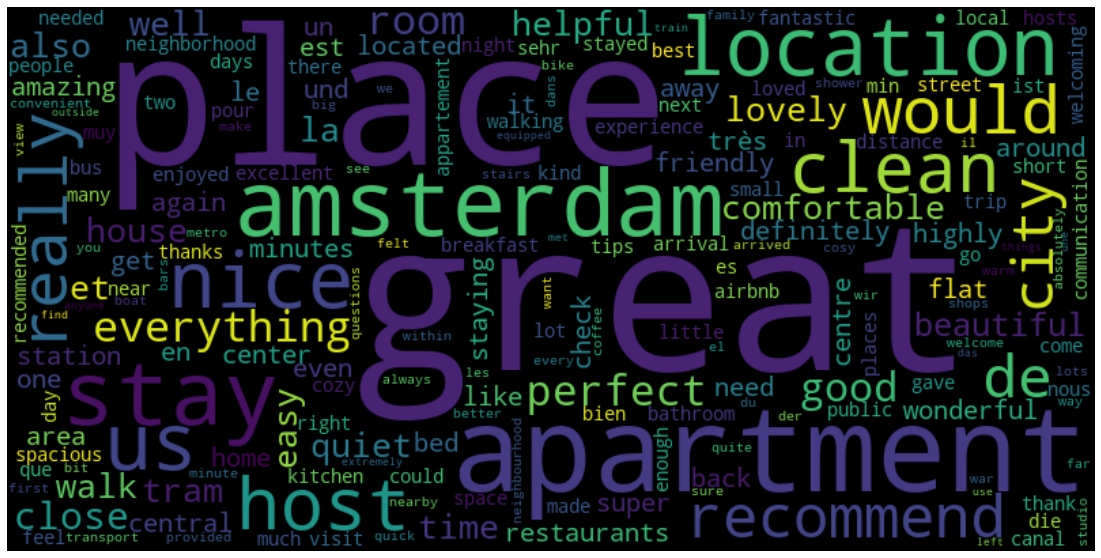

In [0]:
cvec_dict = dict(zip(cvec_df.words, cvec_df.counts))

wordcloud = WordCloud(width=800, height=400)
wordcloud.generate_from_frequencies(frequencies=cvec_dict)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()